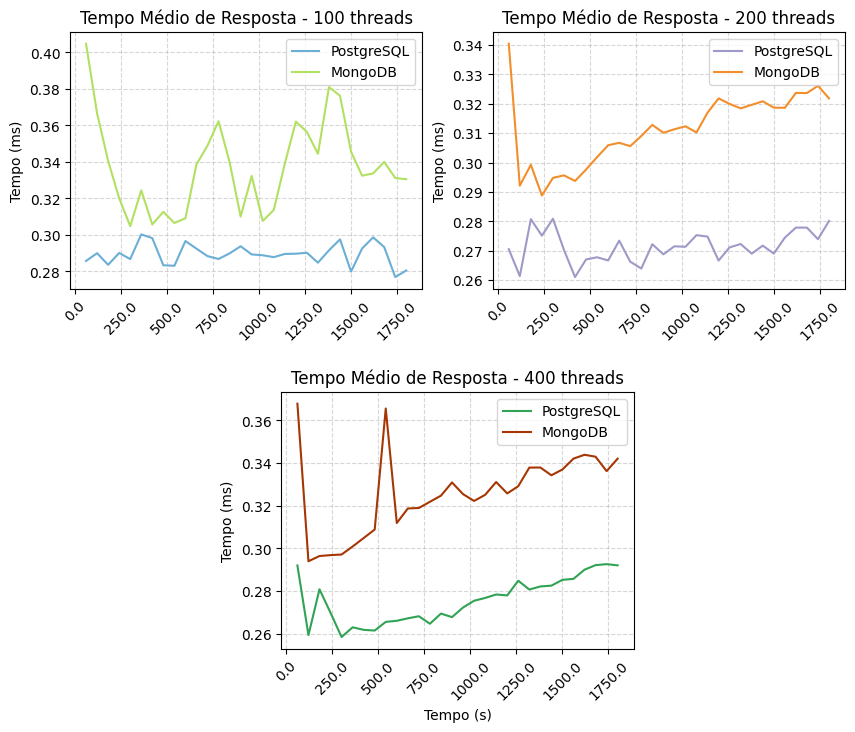

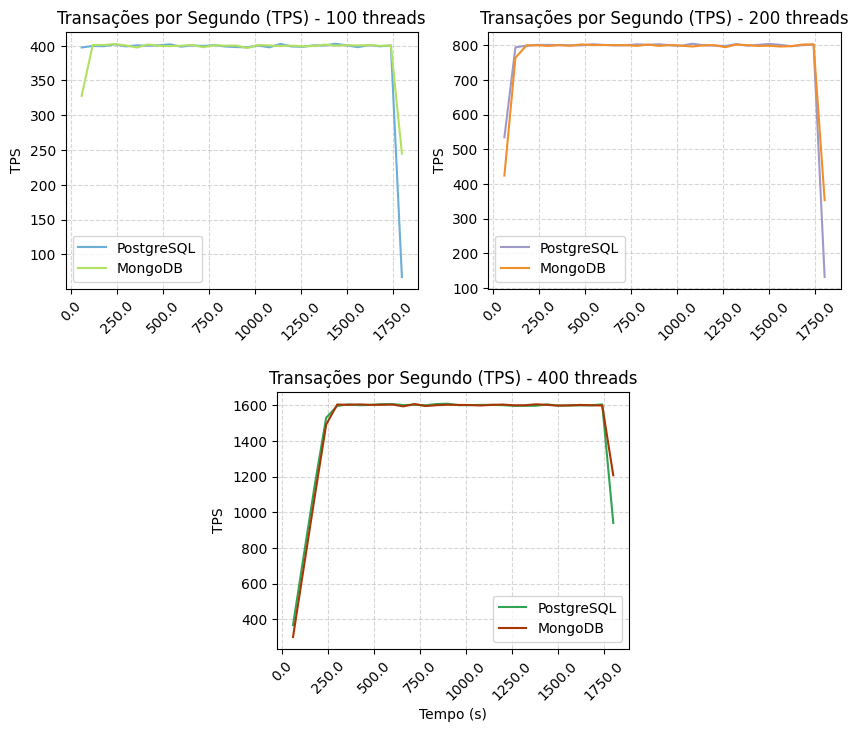

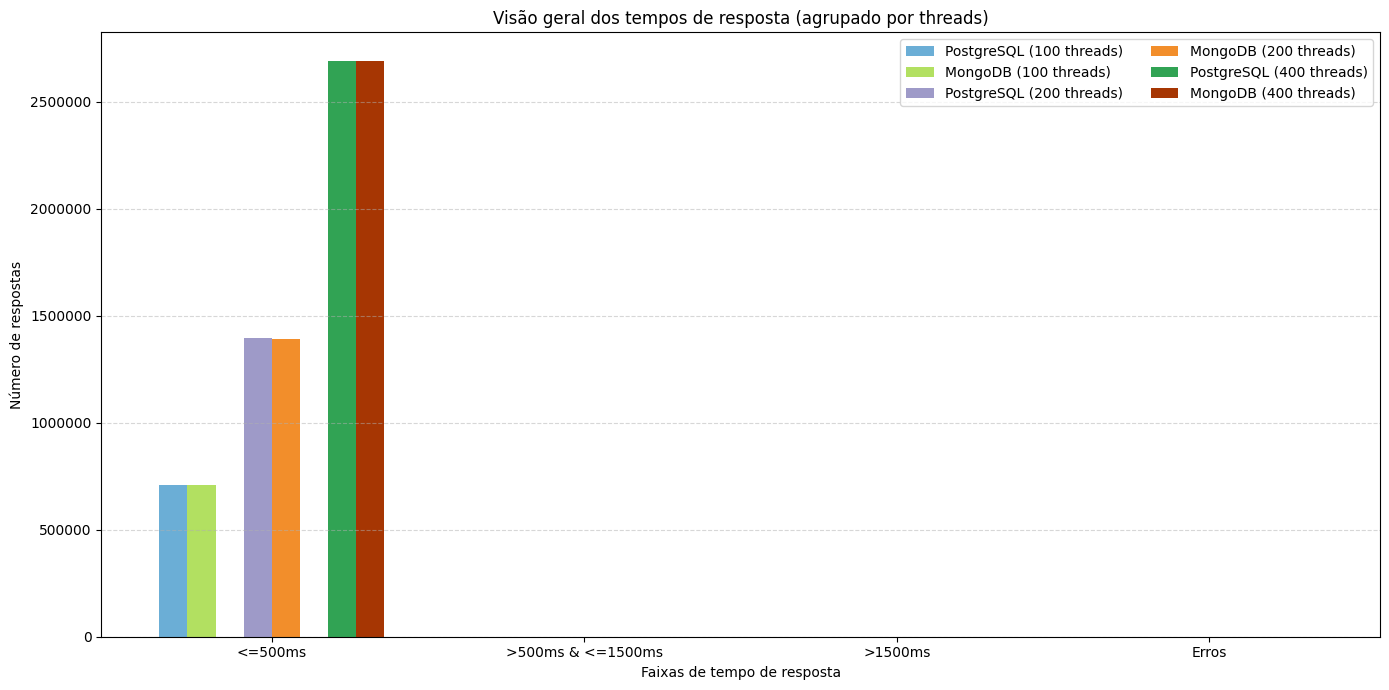

Gráfico salvo em: plots/insert_visao_geral_tempo_resposta_agrupado_threads.png


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import numpy as np
import os

# === CONFIGURAÇÕES ===
workload = 'insert'
scenarios = {
    '100': '60',
    '200': '120',
    '400': '240'
}

db_pg = 'pg'
db_mongo = 'mongo'

output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

def get_color(db, threads):
    color_map = {
        ('PostgreSQL', '100'): '#6BAED6',
        ('MongoDB', '100'): '#B2E061',
        ('PostgreSQL', '200'): '#9E9AC8',
        ('MongoDB', '200'): '#F28E2B',
        ('PostgreSQL', '400'): '#31A354',
        ('MongoDB', '400'): '#A63603',
    }
    return color_map[(db, threads)]

# === FUNÇÃO PARA CARREGAR MÉTRICAS ===
def load_metrics(threads, ramp):
    pg_path = f'output/{db_pg}/1800_seconds_duration/{ramp}_seconds_ramp/{threads}_threads/{workload}_workload/results.csv'
    mongo_path = f'output/{db_mongo}/1800_seconds_duration/{ramp}_seconds_ramp/{threads}_threads/{workload}_workload/results.csv'

    df_pg = pd.read_csv(pg_path)
    df_mongo = pd.read_csv(mongo_path)

    df_pg['timeStamp'] = pd.to_datetime(df_pg['timeStamp'], unit='ms')
    df_mongo['timeStamp'] = pd.to_datetime(df_mongo['timeStamp'], unit='ms')

    df_pg.set_index('timeStamp', inplace=True)
    df_mongo.set_index('timeStamp', inplace=True)

    response_pg = df_pg['elapsed'].resample('1T').mean()
    response_mongo = df_mongo['elapsed'].resample('1T').mean()
    tpm_pg = df_pg['elapsed'].resample('1T').count()
    tpm_mongo = df_mongo['elapsed'].resample('1T').count()
    tps_pg = tpm_pg / 60
    tps_mongo = tpm_mongo / 60

    # converte o índice para segundos
    response_pg.index = (response_pg.index - response_pg.index[0]).total_seconds()
    response_mongo.index = (response_mongo.index - response_mongo.index[0]).total_seconds()
    tps_pg.index = (tps_pg.index - tps_pg.index[0]).total_seconds()
    tps_mongo.index = (tps_mongo.index - tps_mongo.index[0]).total_seconds()

    return response_pg, response_mongo, tps_pg, tps_mongo

# === PLOT COM GRÁFICO DE BAIXO CENTRALIZADO, TOPO COMPACTO ===
def plot_uniform_metric(title, ylabel, extract_fn, filename_prefix):
    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.4, wspace=0.2)

    ax1 = fig.add_subplot(gs[0, 0])  # 100 threads
    ax2 = fig.add_subplot(gs[0, 1])  # 200 threads
    ax3 = fig.add_subplot(gs[1, 0])  # 400 threads
    fig.delaxes(fig.add_subplot(gs[1, 1]))  # Remove gráfico extra

    # centraliza o de baixo manualmente entre os dois de cima
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    width = pos1.width
    center = (pos1.x0 + pos2.x1) / 2
    ax3.set_position([center - width / 2, pos1.y0 - 0.45, width, pos1.height])

    axs = [ax1, ax2, ax3]
    threads_order = ['100', '200', '400']

    for i, threads in enumerate(threads_order):
        ramp = scenarios[threads]
        r_pg, r_m, t_pg, t_m = load_metrics(threads, ramp)
        y_pg, y_m = extract_fn(r_pg, r_m, t_pg, t_m)

        y_pg = y_pg[y_pg.index > 20]
        y_m = y_m[y_m.index > 20]

        ax = axs[i]
        ax.plot(y_pg.index, y_pg.values, label='PostgreSQL', color=get_color('PostgreSQL', threads))
        ax.plot(y_m.index, y_m.values, label='MongoDB', color=get_color('MongoDB', threads))
        ax.set_title(f'{title} - {threads} threads')
        ax.set_ylabel(ylabel)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.tick_params(axis='x', rotation=45)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}'))
        ax.legend()

    axs[2].set_xlabel('Tempo (s)')

    plt.savefig(f'{output_dir}/{filename_prefix}_{workload}_uniforme.png', dpi=300)
    plt.show()
    plt.close()

def plot_response_time_overview():
    ranges = ['<=500ms', '>500ms & <=1500ms', '>1500ms', 'Erros']
    response_data = {'PostgreSQL': {}, 'MongoDB': {}}

    def count_ranges(df):
        count_500 = len(df[df['elapsed'] <= 500])
        count_1500 = len(df[(df['elapsed'] > 500) & (df['elapsed'] <= 1500)])
        count_above = len(df[df['elapsed'] > 1500])
        count_errors = len(df[df['success'] == False]) if 'success' in df.columns else 0
        return [count_500, count_1500, count_above, count_errors]

    for threads, ramp in scenarios.items():
        file_pg = f'output/pg/1800_seconds_duration/{ramp}_seconds_ramp/{threads}_threads/{workload}_workload/results.csv'
        file_mongo = f'output/mongo/1800_seconds_duration/{ramp}_seconds_ramp/{threads}_threads/{workload}_workload/results.csv'

        if not os.path.exists(file_pg) or not os.path.exists(file_mongo):
            print(f"Arquivo não encontrado para {threads} threads. Pulando...")
            continue

        df_pg = pd.read_csv(file_pg)
        df_mongo = pd.read_csv(file_mongo)

        if 'label' in df_mongo.columns:
            df_mongo = df_mongo[~df_mongo['label'].str.contains("database", case=False, na=False)]

        response_data['PostgreSQL'][threads] = count_ranges(df_pg)
        response_data['MongoDB'][threads] = count_ranges(df_mongo)

    # Gráfico
    bar_width = 0.18
    spacing = 2.0
    thread_order = ['100', '200', '400']
    x_base = np.arange(len(ranges)) * spacing

    fig, ax = plt.subplots(figsize=(14, 7))

    for i, threads in enumerate(thread_order):
        if threads not in response_data['PostgreSQL']:
            continue

        offset = (i - 1) * bar_width * 3
        x_group = x_base + offset

        pg_vals = response_data['PostgreSQL'][threads]
        mongo_vals = response_data['MongoDB'][threads]

        ax.bar(x_group - bar_width / 2, pg_vals, bar_width, label=f'PostgreSQL ({threads} threads)', color=get_color('PostgreSQL', threads))
        ax.bar(x_group + bar_width / 2, mongo_vals, bar_width, label=f'MongoDB ({threads} threads)', color=get_color('MongoDB', threads))

    ax.set_xlabel('Faixas de tempo de resposta')
    ax.set_ylabel('Número de respostas')
    ax.set_title('Visão geral dos tempos de resposta (agrupado por threads)')
    ax.set_xticks(x_base)
    ax.set_xticklabels(ranges)
    ax.legend(ncol=2)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.ticklabel_format(style='plain', axis='y')

    plt.tight_layout()
    output_path = f'{output_dir}/{workload}_visao_geral_tempo_resposta_agrupado_threads.png'
    plt.savefig(output_path, dpi=300)
    plt.show()
    print(f"Gráfico salvo em: {output_path}")

# === EXECUÇÃO FINAL ===

# Gráfico: Tempo Médio de Resposta
plot_uniform_metric(
    title='Tempo Médio de Resposta',
    ylabel='Tempo (ms)',
    extract_fn=lambda r_pg, r_m, t_pg, t_m: (r_pg, r_m),
    filename_prefix='tempo_resposta'
)

# Gráfico: TPS
plot_uniform_metric(
    title='Transações por Segundo (TPS)',
    ylabel='TPS',
    extract_fn=lambda r_pg, r_m, t_pg, t_m: (t_pg, t_m),
    filename_prefix='tps'
)

plot_response_time_overview()